In [1]:
%matplotlib inline

from __future__ import print_function, absolute_import, division

##imports
import os
import astropy
import requests
import numpy as np
import pandas as pd
import lightkurve as lk 
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator
import emcee
import statsmodels.api as sm
from scipy.interpolate import interp1d

#from matplotlib import rc
from astropy.modeling import models, fitting


/Users/neisner/opt/anaconda3/envs/exoplanet/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/neisner/.lightkurve/cache. Please move all the files in the legacy directory /Users/neisner/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [4]:
# we can run this code on different sections of the TESS data 
# note that this is so when put into a script we can run a for loop 

section_number = 2

In [5]:
# import the data
search_result = lk.search_lightcurve('TIC 470710327', author = 'SPOC').download_all().stitch()

# store it as time, flux, fluxerr

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

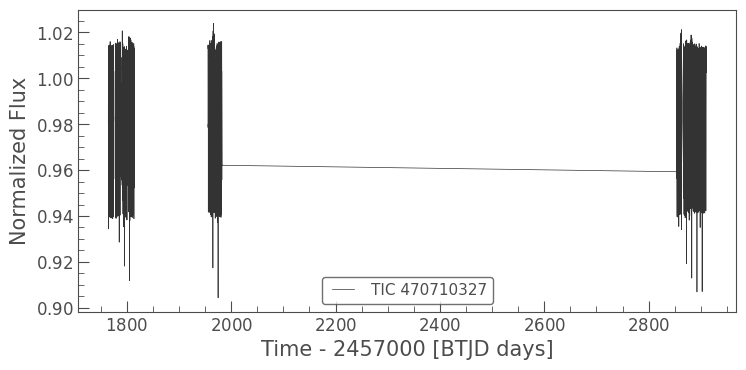

In [7]:
search_result.plot()

In [16]:
def phase_data(time, t0, period):

    '''
    Calualate the phase given a t0 and period.
    '''
    return np.array([-0.5+( ( t - t0-0.5*period) % period) / period for t in time])


(-0.1, 0.1)

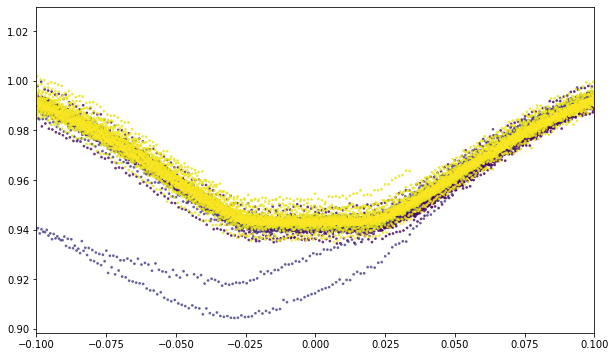

In [17]:
period = 1.1047115 # period of the binary 
t0 = 1766.2685

phase = phase_data(time, t0, period)

fig, ax = plt.subplots(figsize = (10,6))

plt.scatter(phase,flux, s = 3, alpha = 0.7, c = time)

plt.xlim(-0.1,0.1)

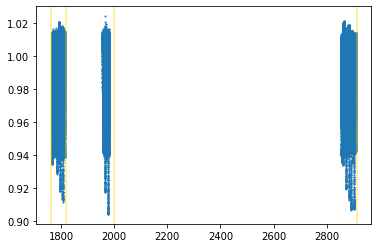

In [19]:
#%matplotlib notebook

fig, ax = plt.subplots()

plt.scatter(time, flux, s = 1)

period_9 = 9.9730
t0_9 = 1795.506 - (period_9 * 3)

for i in [1762, 1820, 1997.6, 2913.3]:
    plt.axvline(i, color = 'gold', alpha = 0.5)

(-0.1, 0.1)

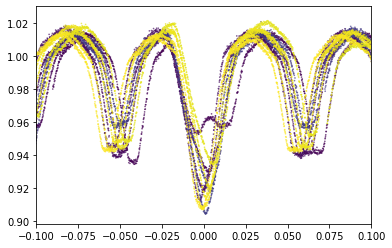

In [7]:
period_9 = 9.9728 # period of the unknown-origin signal

t0_9 = 1795.506 - (period_9 * 3)

phased = np.array([-0.5+( ( t - t0_9-0.5*period_9) % period_9) / period_9 for t in alltime])

fig, ax = plt.subplots()

plt.scatter(phased,allflux, s = 0.5, alpha = 0.6, c = alltime)

plt.xlim(-0.1,0.1)

In [8]:
def sort_on_x(x,y):
    zipped = list(zip(x,y))
    zipped.sort(key=lambda x:x[0])
    x,y = list(zip(*zipped))
    return x,y


def run_binning(x,y,yerr=None,nbins=100,alias=False):
    # Binning function -- takes into account aliasing and error
    # propogation on errorbins
    bwidth = 1./nbins
    if alias==True:
        phStart,phStop = -0.6,0.6
    else:
        phStart,phStop = -0.5,0.5

    bins      = np.arange(phStart,phStop+bwidth,bwidth)
    bin_means = ( np.histogram(x,bins,weights=y)[0] / np.histogram(x,bins)[0] )
    if yerr is not None:
        bin_errs = ( np.histogram(x,bins,weights=yerr)[0] / np.histogram(x,bins)[0] )
    else:
        bin_errs = None

    return bwidth,bins,bin_means,bin_errs


def time_to_ph(time, period=1., t0=0., pshift=0.):
    '''
    converts time to phase from input ephemeris
    DOES NOT ACCOUNT FOR BARYCENTRIC OR HELIOCENTRIC CORRECTION

    input: time (float or array)  --> time point or array
    input: period (float)
    input: t0 (float)
    input: pshift (float) --> phase shift
    ------
    output: phase (float or array)
    '''
    time = np.array(time)
    ph = np.mod((time-t0)/period, 1.0) + pshift
    ph[ph < 0.0] += 1.
    ph[ph > 0.5] -= 1.

    return ph


def interpolate_signal(x_indep,x_model,y_model,nbins):

    
    bin_width,bin_edges,bin_means,_ = run_binning(x_model,y_model,nbins=nbins)
    
    mask = np.isfinite(bin_means) 

    bin_means = bin_means[mask]
    
    bins = bin_edges[:-1]+0.5*bin_width
    
    bins = bins[mask]
    interpolated_model = PchipInterpolator(bins,bin_means,extrapolate=False)
    interpolated_y = interpolated_model(x_indep)

    return interpolated_y,interpolated_model


def model_signal(period,t0,x,y,x1=None,y1=None,nbins=100):

    ph_x = time_to_ph(x,period,t0)
    ph_x_sorted,y_sorted = sort_on_x(ph_x,y)
    y_interpolated, model = interpolate_signal(ph_x,ph_x_sorted,y_sorted,nbins)

    y_model_subtracted = y-y_interpolated

    return y_model_subtracted, y_interpolated, model


def trend_removal_interact(period_a, t0_a, times_original, flux_original, time_cut, flux_cut):

    flux_cut_sub_period_a, flux_cut_period_a_model,\
    flux_cut_period_a_function = model_signal(period_a, t0_a,time_cut,flux_cut)
    
    ph_original = time_to_ph(times_original,period_a,t0_a)
    ph_cut = time_to_ph(time_cut,period_a,t0_a)
    
    flux_original_period_a_model = flux_cut_period_a_function(ph_original)
    flux_original_sub_period_a = flux_original - np.array(flux_original_period_a_model)
    
    fig,axes = plt.subplots(2,1, figsize = (7,8))
    fig.subplots_adjust(bottom=0.2)

    axes[0].plot(ph_original,flux_original,marker = '.', lw = 0, color = 'grey')
    axes[0].plot(ph_cut,flux_cut,marker = '.', lw = 0, color = 'k')
    
    axes[0].plot(ph_original,flux_original_period_a_model,marker = '.', lw = 0, color = 'darkorange', ms = 2)
    
    
    axes[1].plot(ph_original,flux_original_sub_period_a,'k.', alpha = 0.5)
    
    axes[0].set_ylabel(r'$Flux$',fontsize=18)
    axes[1].set_ylabel(r'$Flux$',fontsize=18)
    axes[1].set_xlabel(r'$\Phi$',fontsize=18)
    
    
    axes[0].tick_params(direction='in', length = 3, which ='minor', colors='grey', labelsize=13)
    axes[0].tick_params(axis="y",direction="inout") #, pad= -20)
    axes[0].tick_params(axis="x",direction="inout") #, pad= -17)   
    axes[0].tick_params(axis='both', length = 5, left='on', top='on', right='on', bottom='on')

    axes[1].tick_params(direction='in', length = 3, which ='minor', colors='grey', labelsize=13)
    axes[1].tick_params(axis="y",direction="inout") #, pad= -20)
    axes[1].tick_params(axis="x",direction="inout") #, pad= -17)   
    axes[1].tick_params(axis='both', length = 5, left='on', top='on', right='on', bottom='on')


    #plt.savefig('/Users/Nora/Documents/research/projects/fluffy/figs/sig_removal.png', dpi = 300)
    plt.show()  
    
    return ph_original,times_original, flux_original_sub_period_a, flux_original_period_a_model, ph_cut, flux_cut


In [9]:
data = {'time': search_result.time.value, 'flux': search_result.flux.value, 'err': search_result.flux_err.value}

time_cut = search_result.time.value
flux_cut = search_result.flux.value
err_cut = search_result.flux_err.value

new_mask_w9 = (time_cut > 1790 ) & (time_cut < 1792) 
time_cut = time_cut[~new_mask_w9]
flux_cut = flux_cut[~new_mask_w9]
err_cut = err_cut[~new_mask_w9]

new_mask_w9 = (time_cut > 1814 ) & (time_cut < 1815) 
time_cut = time_cut[~new_mask_w9]
flux_cut = flux_cut[~new_mask_w9]
err_cut = err_cut[~new_mask_w9]


In [10]:

for i in range(0,1030):
    
    mask = (time_cut > ((t0_9 + (i*period_9))-0.35)) & (time_cut < ((t0_9 + (i*period_9))+0.35))

    time_cut = time_cut[~mask]
    flux_cut = flux_cut[~mask]
    err_cut = err_cut[~mask]
    
new_mask = (time_cut > 1790 ) & (time_cut < 1792) 
time_cut = time_cut[~new_mask]
flux_cut = flux_cut[~new_mask]
err_cut = err_cut[~new_mask]

new_mask = (time_cut > 1814 ) & (time_cut < 1815) 
time_cut = time_cut[~new_mask]
flux_cut = flux_cut[~new_mask]
err_cut = err_cut[~new_mask]



period_a = period
t0_a = t0

good_mask = np.isfinite(np.array(data['time'])) * np.isfinite(np.array(data['flux'])) 

alltime_ar = np.array(data['time'])[good_mask]
allflux_ar = np.array(data['flux'])[good_mask]

good_mask_cut = np.isfinite(np.array(time_cut)) * np.isfinite(np.array(flux_cut)) 
good_mask_cut_w9 = np.isfinite(np.array(time_cut)) * np.isfinite(np.array(flux_cut)) 


alltime_ar_cut = np.array(time_cut)[good_mask_cut]
allflux_ar_cut = np.array(flux_cut)[good_mask_cut]

alltime_ar_cut_w9 = np.array(time_cut)[good_mask_cut_w9]
allflux_ar_cut_w9 = np.array(flux_cut)[good_mask_cut_w9]

#plt.scatter(time_cut_w9, flux_cut_w9, s = 1)


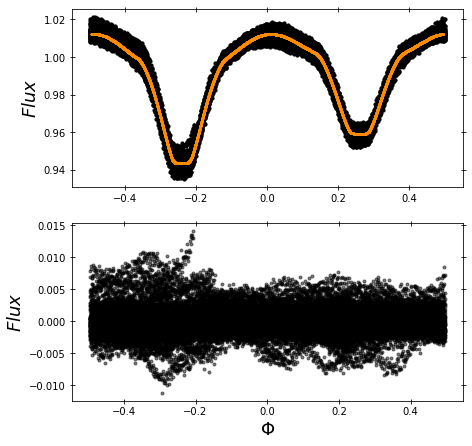

In [11]:
cut_times = [1762, 1820, 1997.6, 2913.3] #[1762, 1776.6, 1790.4, 1802.6, 1820, 1971.02, 1997.6, 2865.1, 2882.221, 2896.149, 2913.3] # do manually for now
color = ['r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k','r', 'k']


mask = (alltime_ar_cut > cut_times[section_number]) & (alltime_ar_cut < cut_times[section_number+1])
mask_w9 = (alltime_ar_cut_w9 > cut_times[section_number]) & (alltime_ar_cut_w9 < cut_times[section_number+1])

alltime_ar_cut_w9 = alltime_ar_cut_w9[mask_w9]
allflux_ar_cut_w9 = allflux_ar_cut_w9[mask_w9]

alltime_ar_cut = alltime_ar_cut[mask]
allflux_ar_cut = allflux_ar_cut[mask]

ph_original, times_original, flux_original_sub_period_a, model, ph_cut, flux_cut = trend_removal_interact(period_a, 0.1, alltime_ar_cut, allflux_ar_cut, alltime_ar_cut, allflux_ar_cut)


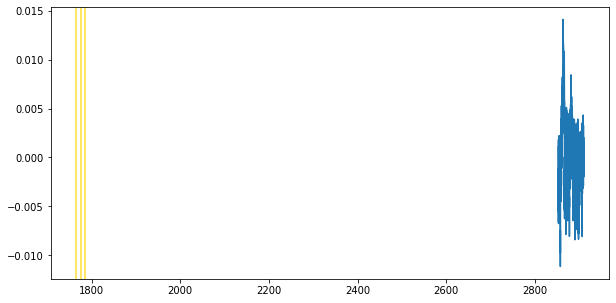

In [14]:
plt.figure(figsize=(10,5))

for i in range (0,3):

    plt.axvline(t0_9 + (i*period_9), alpha = 0.8, color = 'gold', zorder = -2)

plt.plot(times_original, flux_original_sub_period_a)

plt.show()

In [15]:
# Remove the overall trend and then re do the fitting to remoe the signal to see whether we can improve on the trend removal
import filters
import norm

times_cut = times_original
flux_cut = flux_original_sub_period_a

T_dur = 5

nmed = int(30*3*T_dur)
nmed = 2*int(nmed/2)+1


ff = filters.NIF(np.array(flux_cut),nmed,10,fill=True,verbose=True)

# first number is three times transit durations, the second quite small (10,20 )
l = np.isfinite(ff)



10 34732 451
reached the end
NIF: 0 0 -1 0.0010379586287273795
10 33729 451
reached the end
NIF: 1 1319 0 0.0009963735879141473
10 33552 451
reached the end
NIF: 2 1496 1319 0.0009910851705255122
10 33526 451
reached the end
NIF: 3 1522 1496 0.0009895766337887722
10 33522 451
reached the end
NIF: 4 1526 1522 0.0009893947232741513


35048 35048
10 34732 451
reached the end
NIF: 0 0 -1 0.0010379586287273795
10 33729 451
reached the end
NIF: 1 1319 0 0.0009963735879141473
10 33552 451
reached the end
NIF: 2 1496 1319 0.0009910851705255122
10 33526 451
reached the end
NIF: 3 1522 1496 0.0009895766337887722
10 33522 451
reached the end
NIF: 4 1526 1522 0.0009893947232741513


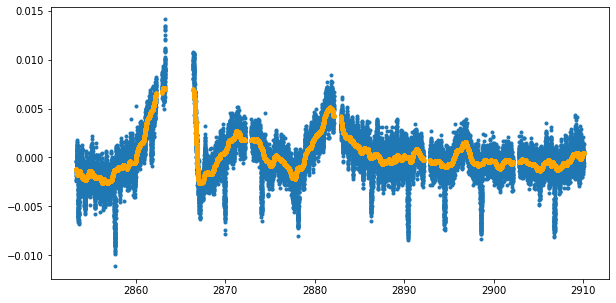

In [16]:

g = interp1d(times_cut[l],ff[l],bounds_error=False,fill_value=np.nan)

ff = g(times_cut)
plt.figure(figsize=(10,5))
plt.plot(times_cut,flux_cut,'.')
plt.plot(times_cut,ff,'.', color = 'orange')
print(np.isfinite(ff).sum(),len(ff))


T_dur = 5

nmed = int(30*3*T_dur)
nmed = 2*int(nmed/2)+1


ff = filters.NIF(np.array(flux_cut),nmed,10,fill=True,verbose=True)

# first number is three times transit durations, the second quite small (10,20 )
l = np.isfinite(ff)

g = interp1d(times_cut[l],ff[l],bounds_error=False,fill_value=np.nan)

ff = g(times_original)


35048 35048


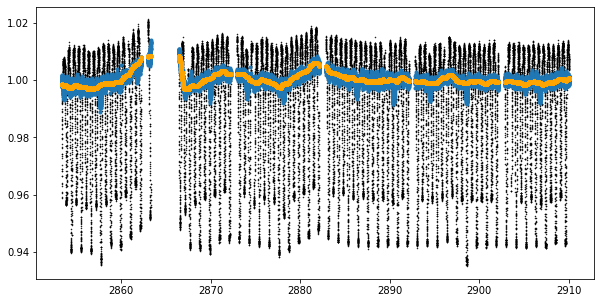

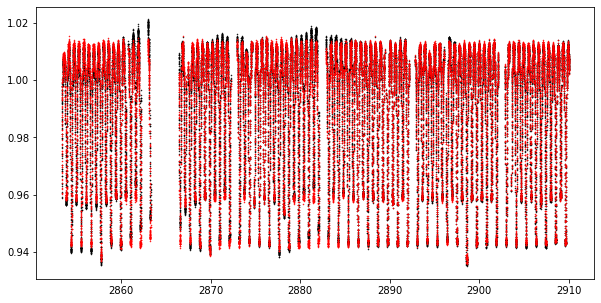

In [17]:
plt.figure(figsize=(10,5))

plt.plot(alltime_ar_cut,allflux_ar_cut,'.', color = 'k', ms = 1) 

print(np.isfinite(ff).sum(),len(ff))
plt.plot(times_cut,flux_cut+1,'.')
plt.plot(times_original,((ff*1.2)+1),'.', color = 'orange')

flux_detrended_sig_rem = allflux_ar_cut - (ff)
time_detrended_sig_rem = times_original

fig, ax = plt.subplots(figsize=(10,5))

plt.plot(alltime_ar_cut, allflux_ar_cut,'.k', ms = 1)
plt.plot(time_detrended_sig_rem, flux_detrended_sig_rem,'.r', alpha = 1, ms = 1)



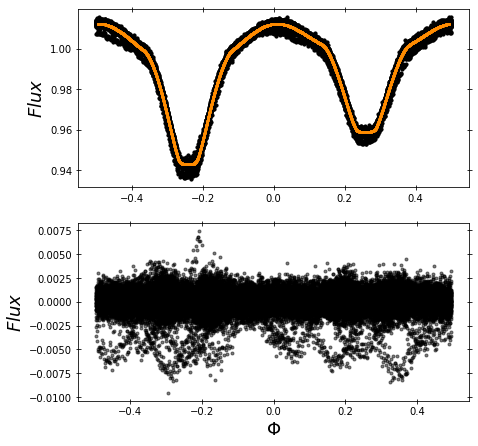

In [18]:
# now that it has been detrended, run the phase folding again:

ph_original, times_original, flux_original_sub_period_a, model, ph_cut, flux_cut = trend_removal_interact(period_a, 0.1, time_detrended_sig_rem, flux_detrended_sig_rem, time_detrended_sig_rem, flux_detrended_sig_rem)

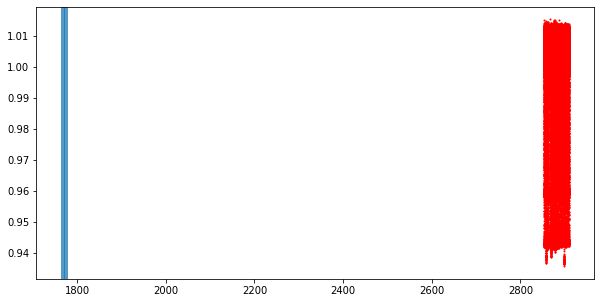

In [19]:
plt.figure(figsize=(10,5))

period_4 =  4.09175
t0_4 = 1765.185

for i in range(0,4):
    plt.axvline(t0_4 + (i*period_4))
plt.plot(time_detrended_sig_rem, flux_detrended_sig_rem,'.r', alpha = 1, ms = 2)

plt.show()

#np.savetxt("/Users/Nora/Documents/research/projects/fluffy/fluffy_removesig/LC_9d_removed.txt", np.array([time_detrended_sig_rem, flux_detrended_sig_rem]).T)

In [22]:
lowess = sm.nonparametric.lowess

#plt.plot(ph_original, model, lw = 0, marker = '.')   

model_smooth = lowess(model, ph_original,return_sorted = True, frac = 0.01, it = 5)

model_smooth_x = model_smooth[:,0]
model_smooth_y = model_smooth[:,1]

gradient = np.gradient(model_smooth_y, model_smooth_x)


In [23]:
gradient_smooth0 = lowess(gradient, model_smooth_x,return_sorted = True, frac = 0.01, it = 5)

gradient_smooth0_x = gradient_smooth0[:,0]
gradient_smooth0_y = gradient_smooth0[:,1]

gradient_smooth = lowess(gradient_smooth0_y, gradient_smooth0_x,return_sorted = True, frac = 0.01, it = 5)

gradient_smooth_x = gradient_smooth[:,0]
gradient_smooth_y = gradient_smooth[:,1]


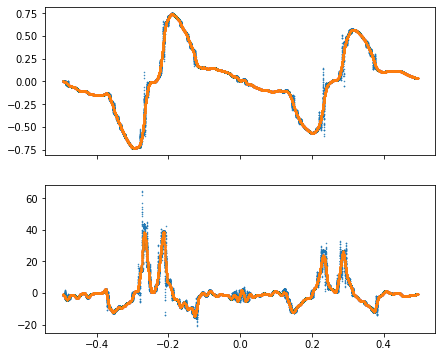

In [24]:
fig,ax = plt.subplots(2,1, figsize = (7,6), sharex = True)

ax[0].plot(model_smooth_x, gradient, lw = 0, marker = '.', ms = 1)
ax[0].plot(gradient_smooth_x, gradient_smooth_y, lw = 0, marker = '.', ms = 1)

derif2 = np.gradient(gradient_smooth_y, gradient_smooth_x)

derif2_smooth = lowess(derif2, gradient_smooth_x, return_sorted = True, frac = 0.01, it = 5)

derif2_smooth_x = derif2_smooth[:,0]
derif2_smooth_y = derif2_smooth[:,1]

ax[1].plot(gradient_smooth_x, derif2, lw = 0, marker = '.', ms = 1)
ax[1].plot(derif2_smooth_x, derif2_smooth_y, lw = 0, marker = '.', ms = 1)

plt.show()

In [26]:
def log_prior(theta):
    amp, t0, width,slope = theta
    
    # amp, t0, width, slope
    # -0.044, 0.257, 0.049222498391319536, -0.55
    

    if  (-1 < amp < 0) and ( -0.5 < t0 < 0.5) and (0 < width < 1) and (-1 < slope < 0):
        return 0.0


    return -np.inf


def log_likelihood(theta, x, y, yerr):
    
    amp, t0, width, slope   = theta
    
    t_init = models.Trapezoid1D(amplitude=amp, x_0=t0, width=width, slope=slope)
    model = t_init(x)
    
    return -0.5 * np.sum((y - model) ** 2 / (yerr ** 2) )


def log_probability(theta, x, y, yerr):
    
    # check that the priors are satisfied
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


def get_starting_positions(start_vals, nwalkers=128):

    p0 = np.array( [ [ val+1e-5*np.random.randn()
                       for jj,val in enumerate(start_vals) ]
                      for i in range(nwalkers) ] )
    
    yield p0


In [27]:
np.median(err_cut)

print(-0.365 + 0.0275 + 0.01)
print(-0.0863-0.032 - 0.01)

-0.32749999999999996
-0.1283


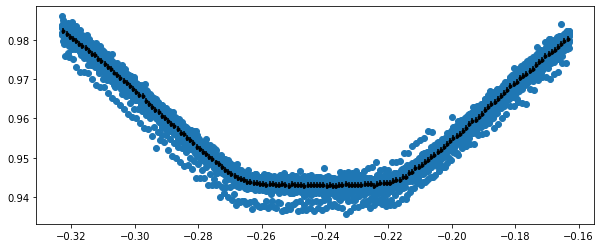

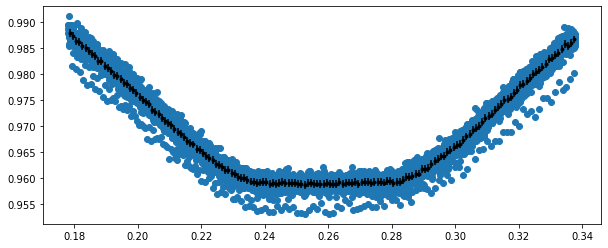

In [28]:
# for primary 
def prepare_data_elcipse(time, phase, flux, err, start_ph, end_ph):

    df = pd.DataFrame({'time':time,'phase':phase, 'flux':flux, 'err':err})

    df_in_phase = df[(df['phase'] > start_ph) & (df['phase'] < end_ph) ]

    return df_in_phase

midpoint_p = -0.243
midpoint_s = 0.258
window_width = 0.08

df_in_phase_primary = prepare_data_elcipse(times_original, ph_cut, flux_cut, len(flux_cut) * [0.00076063], midpoint_p - window_width, midpoint_p + window_width)#-0.315, -0.0863)        
df_in_phase_secondary = prepare_data_elcipse(times_original, ph_cut, flux_cut, len(flux_cut) * [0.00076063], midpoint_s-window_width, midpoint_s+window_width) #-0.315, -0.0863)        

ph_primary0  = df_in_phase_primary.phase
flux_primary0 = df_in_phase_primary.flux
err_primary0 = df_in_phase_primary.err

ph_secondary0  = df_in_phase_secondary.phase
flux_secondary0 = df_in_phase_secondary.flux
err_secondary0 = df_in_phase_secondary.err


def run_binning(x,y,period=1.,yerr=None,nbins=100):
    # Binning function -- takes into account aliasing and error
    # propogation on errorbins
    
    bwidth = 1./nbins
    phStart,phStop = np.nanmin(x), np.nanmax(x)

    bins      = np.arange(phStart,phStop+bwidth,bwidth)
    bin_means = ( np.histogram(x,bins,weights=y)[0] / np.histogram(x,bins)[0] )
    if yerr is not None:
        bin_errs = ( np.histogram(x,bins,weights=yerr)[0] / np.histogram(x,bins)[0] )
    else:
        bin_errs = None
    
    bins =  bins[:-1] + 0.5*bwidth
    
    return bins,bin_means,bin_errs



ph_binned,flux_binned,err_binned = run_binning(ph_primary0,flux_primary0,period=1.,yerr=err_primary0,nbins=1000)
ph_binned_s,flux_binned_s,err_binned_s = run_binning(ph_secondary0,flux_secondary0,period=1.,yerr=err_secondary0,nbins=1000)


fig = plt.subplots(figsize=(10, 4), sharex=True)

plt.errorbar(ph_binned, flux_binned, yerr=err_binned, fmt=".k", capsize=0, zorder = 2)
plt.scatter(ph_primary0, flux_primary0, zorder = -2)

ph_primary =   ph_primary0 #ph_binned #ph_primary0 ph_binned
flux_primary = flux_primary0 -1 #flux_binned - 1 #flux_primary0 flux_binned
err_primary = err_primary0 #err_binned #err_primary0 err_binned

plt.show()

# -- -- -- -- -- -- -- -- -- 
fig = plt.subplots(figsize=(10, 4), sharex=True)

plt.errorbar(ph_binned_s, flux_binned_s, yerr=err_binned_s, fmt=".k", capsize=0, zorder = 2)
plt.scatter(ph_secondary0, flux_secondary0, zorder = -2)

ph_secondary =   ph_secondary0 #ph_binned #ph_primary0 ph_binned
flux_secondary = flux_secondary0 -1 #flux_binned - 1 #flux_primary0 flux_binned
err_secondary = err_secondary0 #err_binned #err_primary0 err_binned
 

plt.show()

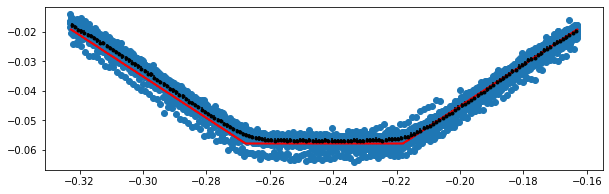

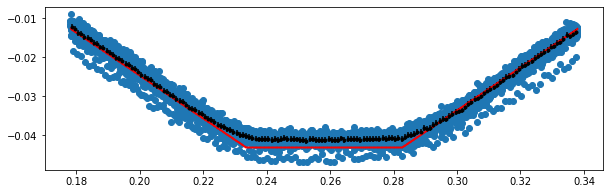

In [29]:
def model_fit(x, amp, t0, width, slope):

    t_init = models.Trapezoid1D(amplitude=amp, x_0=t0, width=width, slope=slope)

    return t_init(x)


fig = plt.subplots(figsize=(10, 3), sharex=True)

#alpha0, alpha1, t0, d, Tau

plt.errorbar(ph_binned, flux_binned-1, yerr=err_binned, fmt=".k", capsize=0, zorder = 2)
plt.scatter(ph_primary0, flux_primary0-1, zorder = -2)

#amp, t0, width, slope

midpoint_p
midpoint_s

plt.plot(ph_primary0, model_fit(ph_primary0, -0.05787605317820328, midpoint_p, 0.049222498391319536, -0.7044735219536102), lw = 0, marker = '.', markersize = 0.5, alpha=1, zorder = 2, color= 'red')


fig = plt.subplots(figsize=(10, 3), sharex=True)

#alpha0, alpha1, t0, d, Tau

plt.errorbar(ph_binned_s, flux_binned_s-1, yerr=err_binned_s, fmt=".k", capsize=0, zorder = 2)
plt.scatter(ph_secondary0, flux_secondary0-1, zorder = -2)
plt.plot(ph_secondary0, model_fit(ph_secondary0, -0.043, midpoint_s, 0.049222498391319536, -0.55), lw = 0, marker = '.', markersize = 0.5, alpha=1, zorder = 2, color= 'red')


In [30]:
start_vals = [-0.05787605317820328, midpoint_p, 0.049222498391319536, -0.7044735219536102]
start_vals_s = [-0.044, midpoint_s, 0.049222498391319536, -0.55]

pos = list(get_starting_positions(start_vals,nwalkers=128))[0]
pos_s = list(get_starting_positions(start_vals_s,nwalkers=128))[0]

nwalkers = 128
ndim = len(start_vals)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ph_primary, flux_primary, err_primary))
sampler_s = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ph_secondary, flux_secondary, err_secondary))

sampler.run_mcmc(pos, 1000, progress=True)
sampler_s.run_mcmc(pos_s, 1000, progress=True)

100%|███████████████████████████████████████| 1000/1000 [00:45<00:00, 22.21it/s]


State([[-0.04087608  0.25888064  0.05501025 -0.53691909]
 [-0.04085123  0.25888567  0.05509174 -0.53600152]
 [-0.04087791  0.25885296  0.05495663 -0.5367333 ]
 [-0.04089646  0.25889108  0.0547844  -0.53486649]
 [-0.04088044  0.2588174   0.05492278 -0.53517152]
 [-0.0408799   0.25884769  0.05479198 -0.53445328]
 [-0.04090431  0.25885776  0.05497255 -0.53628722]
 [-0.04091089  0.25890665  0.05469496 -0.53463179]
 [-0.04087527  0.2588659   0.05501536 -0.53624628]
 [-0.04087193  0.2588826   0.05494263 -0.536237  ]
 [-0.04088009  0.25885243  0.05482406 -0.5345318 ]
 [-0.04089659  0.25887107  0.05456681 -0.53365363]
 [-0.04088459  0.25889096  0.05510498 -0.53743542]
 [-0.0408834   0.25884196  0.05473476 -0.53491313]
 [-0.04088871  0.25884849  0.05480598 -0.53534329]
 [-0.04092495  0.25883394  0.05477803 -0.53651629]
 [-0.04089297  0.25884088  0.05487629 -0.53668209]
 [-0.04090671  0.25885382  0.05474462 -0.53591368]
 [-0.0408856   0.25882906  0.05490603 -0.53616454]
 [-0.04085418  0.25891102

In [31]:
tau = sampler.get_autocorr_time(tol=0)
print (tau)
tau_s = sampler_s.get_autocorr_time(tol=0)
print (tau_s)

[47.43604172 42.91627626 25.64932605 81.6386649 ]
[54.77956252 42.38187731 39.49382939 93.37971764]


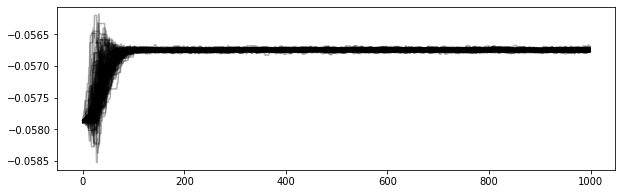

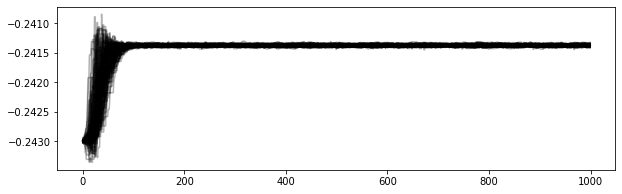

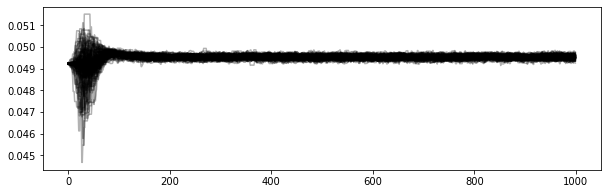

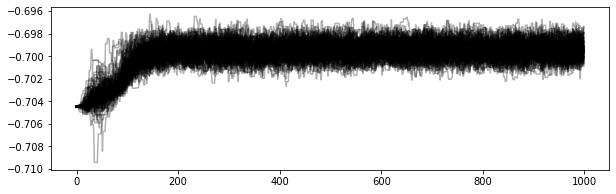

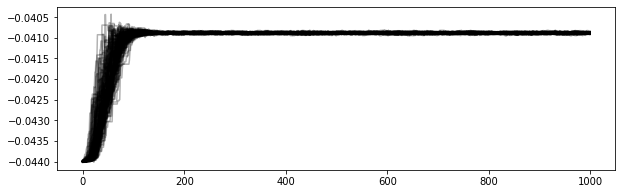

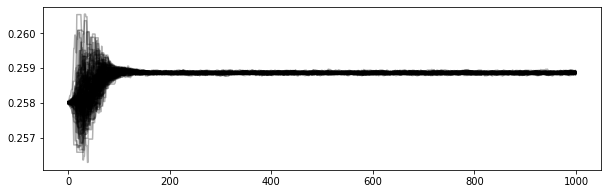

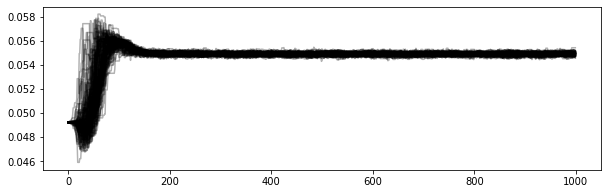

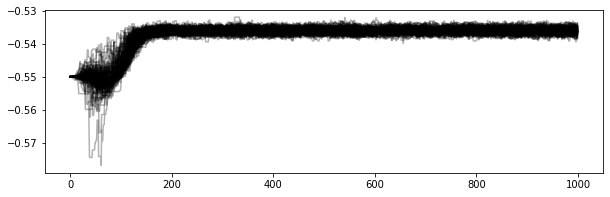

In [32]:
samples = sampler.get_chain()
labels = ['amp', 'x_0', 'width', 'slope']

for i in range(ndim):
    fig, axes = plt.subplots(figsize=(10, 3))
    plt.plot(samples[:, :, i], "k", alpha=0.3)
    #ax.set_xlim(0, len(samples))
    #plt.ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)
    plt.show()
    
samples_s = sampler_s.get_chain()
labels = ['amp', 'x_0', 'width', 'slope']

for i in range(ndim):
    fig, axes = plt.subplots(figsize=(10, 3))
    plt.plot(samples_s[:, :, i], "k", alpha=0.3)
    #ax.set_xlim(0, len(samples))
    #axes.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)
    plt.show()
    

In [33]:
flat_samples = sampler.get_chain(discard=600, thin=15, flat=True)
print(flat_samples.shape)
flat_samples_s = sampler_s.get_chain(discard=600, thin=15, flat=True)
print(flat_samples_s.shape)

(3328, 4)
(3328, 4)


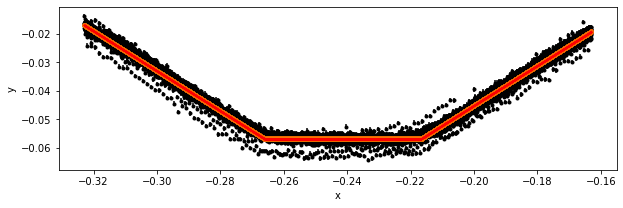

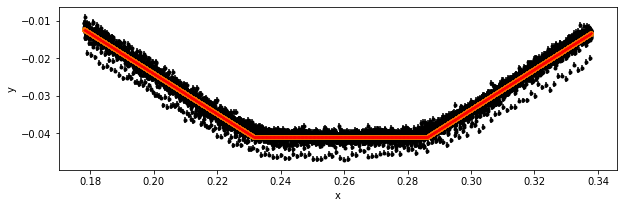

In [34]:
fig = plt.subplots(figsize=(10, 3), sharex=True)

mean_amp = np.median(flat_samples[:,0])
mean_t0 = np.median(flat_samples[:,1])
mean_width = np.median(flat_samples[:,2])
mean_slope = np.median(flat_samples[:,3])

#plt.plot(ph_secondary0, model_fit(ph_secondary0, 0.985, -0.03, 0.3, 0.035, 1.9), lw = 0, marker = '.', markersize = 0.5, alpha=1, zorder = 2, color= 'red')
#x, alpha0, alpha1, t0, d, Tau



inds = np.random.randint(len(flat_samples), size=100)

for ind in inds:
    sample = flat_samples[ind]
    
    model = model_fit(ph_primary, sample[0], sample[1], sample[2], sample[3])
    plt.plot(ph_primary, model, "C1", lw = 0, marker = '.',alpha=0.1, zorder = 2)
    
    
plt.errorbar(ph_primary, flux_primary, yerr=err_primary, fmt=".k", capsize=0, zorder = -2)

model_mean = model_fit(ph_primary, mean_amp, mean_t0, mean_width, mean_slope)
plt.plot(ph_primary, model_mean, lw = 0, marker = '.', markersize = 1, alpha=1, zorder = 2, color= 'red')

plt.xlabel("x")
plt.ylabel("y");

plt.show()

# ----  ----  ---- ----

fig = plt.subplots(figsize=(10, 3), sharex=True)

mean_amp_s = np.median(flat_samples_s[:,0])
mean_t0_s = np.median(flat_samples_s[:,1])
mean_width_s = np.median(flat_samples_s[:,2])
mean_slope_s = np.median(flat_samples_s[:,3])


inds_s = np.random.randint(len(flat_samples_s), size=100)

for ind in inds_s:
    sample_s = flat_samples_s[ind]
    
    model = model_fit(ph_secondary, sample_s[0], sample_s[1], sample_s[2], sample_s[3])
    plt.plot(ph_secondary, model, "C1", lw = 0, marker = '.',alpha=0.1, zorder = 2)
    


plt.errorbar(ph_secondary, flux_secondary, yerr=err_secondary, fmt=".k", capsize=0, zorder = -2)

model_mean = model_fit(ph_secondary, mean_amp_s, mean_t0_s, mean_width_s, mean_slope_s)
plt.plot(ph_secondary, model_mean, lw = 0, marker = '.', markersize = 1, alpha=1, zorder = 2, color= 'red')

plt.xlabel("x")
plt.ylabel("y");

plt.show()

In [35]:
def log_prior_fitting(theta):
    t0, offset = theta
    
    if  (-0.5 < t0 < 0.5) and (-1 < offset < 2):
        return 0.0
    return -np.inf


def log_likelihood_fitting(theta, x, y, yerr):
    
    t0, offset  = theta
    
    t_init = models.Trapezoid1D(amplitude=mean_amp, x_0=t0, width=mean_width, slope=mean_slope)
    model = t_init(x) + offset
    
    return -0.5 * np.sum((y - model) ** 2 / (yerr ** 2) )


def log_probability_fitting(theta, x, y, yerr):
    
    # check that the priors are satisfied
    lp = log_prior_fitting(theta)
    if not np.isfinite(lp):
        return -np.inf
    lnp = lp + log_likelihood_fitting(theta, x, y, yerr)

    return lnp


def log_likelihood_fitting_s(theta, x, y, yerr):
    
    t0, offset  = theta
    
    t_init = models.Trapezoid1D(amplitude=mean_amp_s, x_0=t0, width=mean_width_s, slope=mean_slope_s)
    model = t_init(x) + offset
    
    return -0.5 * np.sum((y - model) ** 2 / (yerr ** 2) )


def log_probability_fitting_s(theta, x, y, yerr):
    
    # check that the priors are satisfied
    lp = log_prior_fitting(theta)
    if not np.isfinite(lp):
        return -np.inf
    lnp = lp + log_likelihood_fitting_s(theta, x, y, yerr)

    return lnp

def get_starting_positions_fitting(start_vals, nwalkers=64):

    p0 = np.array( [ [ val+1e-5*np.random.randn()
                       for jj,val in enumerate(start_vals) ]
                      for i in range(nwalkers) ] )
    
    yield p0



In [36]:
time_primary  = df_in_phase_primary.time
ph_primary  = df_in_phase_primary.phase
flux_primary = df_in_phase_primary.flux - 1
err_primary = df_in_phase_primary.err

time_secondary  = df_in_phase_secondary.time
ph_secondary  = df_in_phase_secondary.phase
flux_secondary = df_in_phase_secondary.flux - 1
err_secondary = df_in_phase_secondary.err


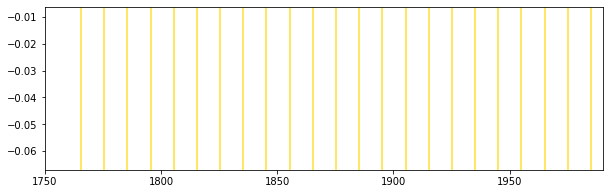

In [37]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(time_secondary,flux_secondary , s = 1)
plt.scatter(time_primary,flux_primary , s = 1)

for i in range (0,55):

    plt.axvline(t0_9 + (i*period_9), alpha = 0.8, color = 'gold', zorder = -2)
    #plt.axvline(t0_4 + (i*period_4), alpha = 0.8, color = 'grey', zorder = -2)

    plt.xlim(1750,1990)
    

plt.show()

Creating new manifest file
Creating new manifest file
yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.59it/s]


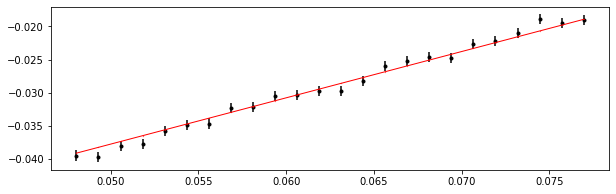

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 94.38it/s]


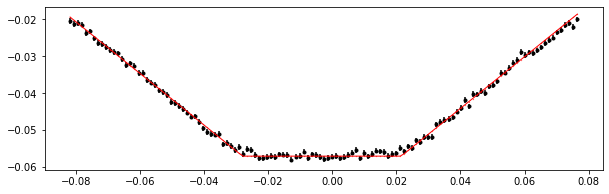

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.50it/s]


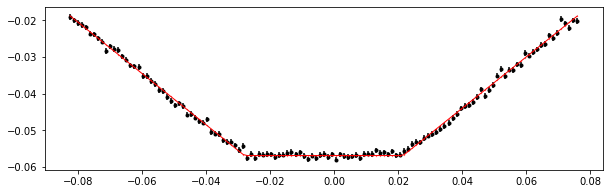

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.16it/s]


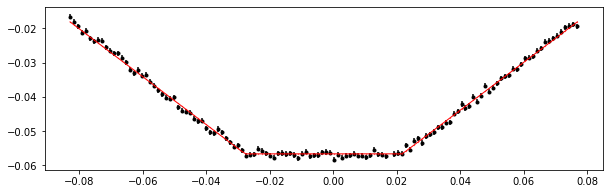

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.27it/s]


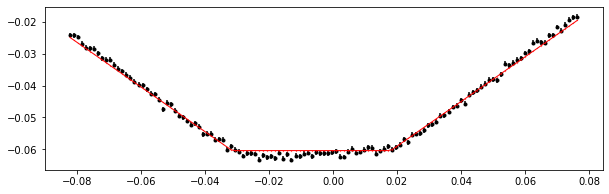

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.67it/s]


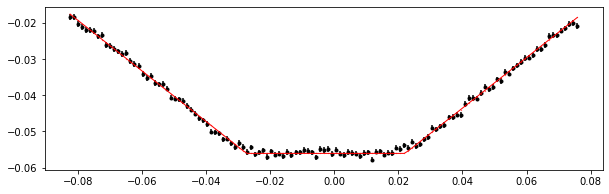

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 94.62it/s]


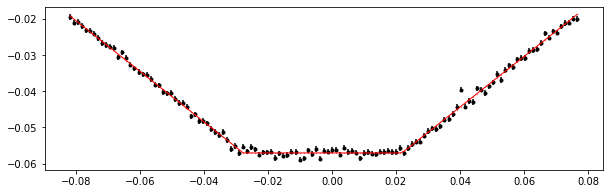

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 96.59it/s]


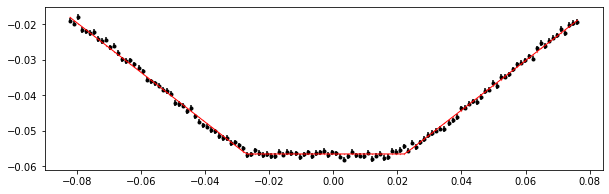

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 96.69it/s]


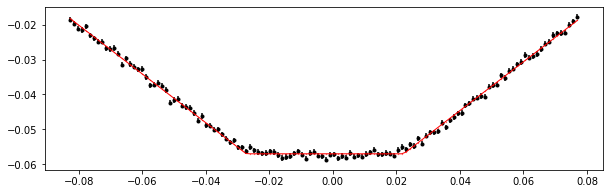

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 93.61it/s]


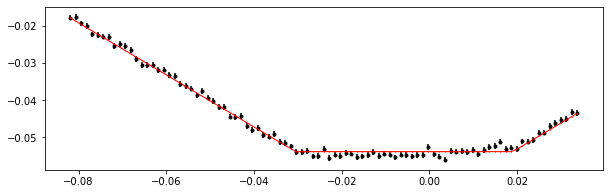

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 95.17it/s]


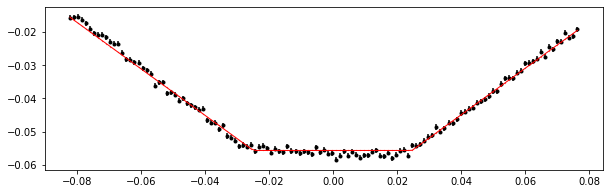

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.01it/s]


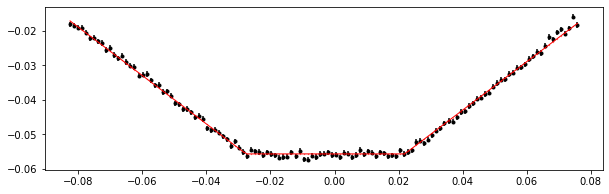

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 96.25it/s]


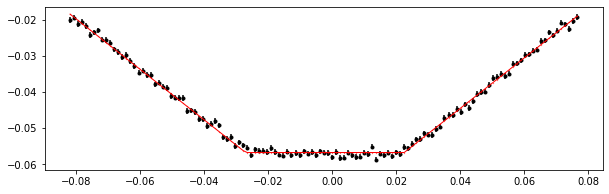

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 96.00it/s]


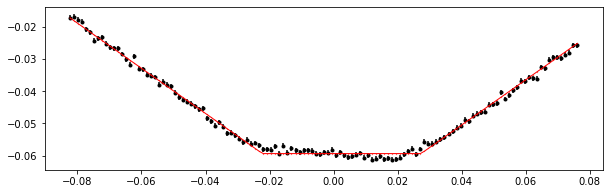

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 95.76it/s]


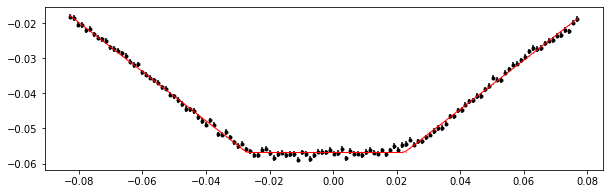

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 96.30it/s]


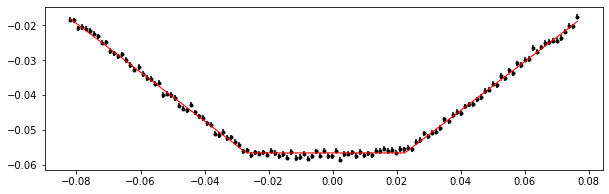

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.66it/s]


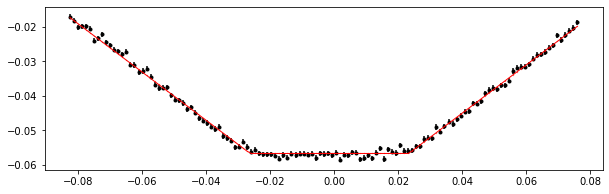

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.09it/s]


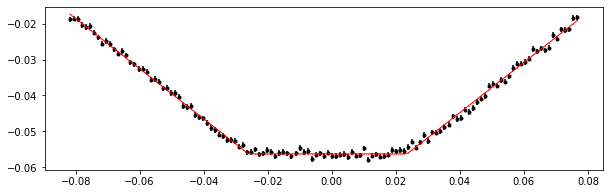

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.63it/s]


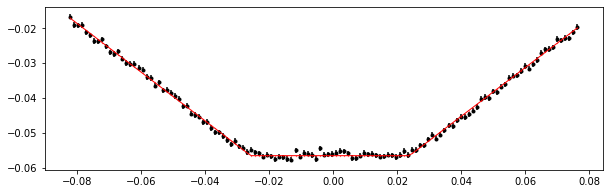

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.13it/s]


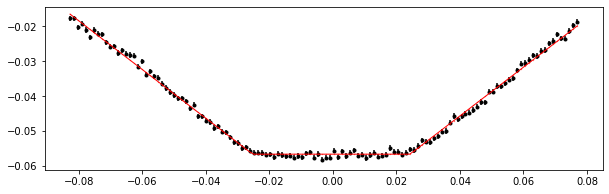

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.50it/s]


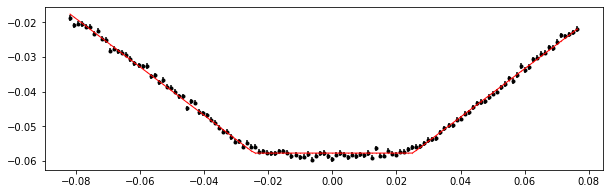

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.23it/s]


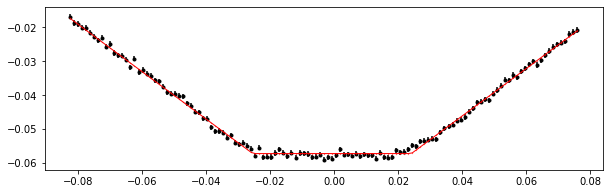

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.31it/s]


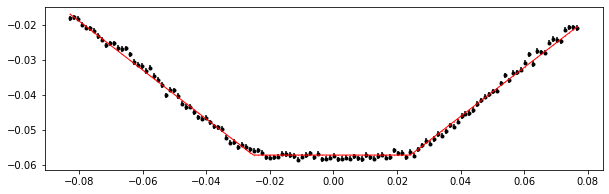

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.36it/s]


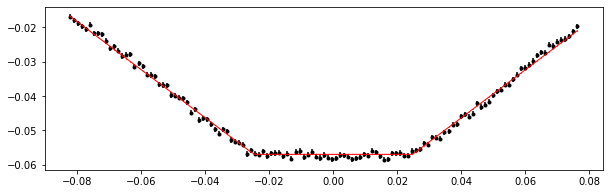

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.03it/s]


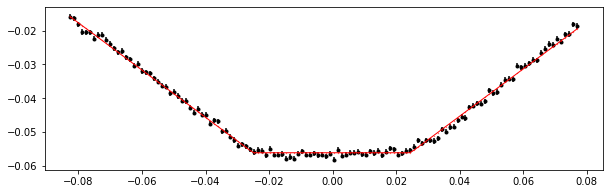

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 96.05it/s]


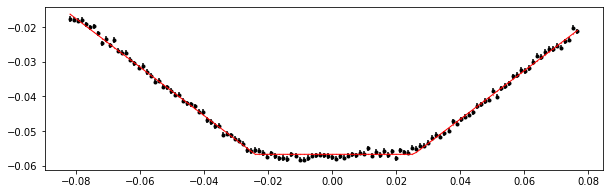

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.39it/s]


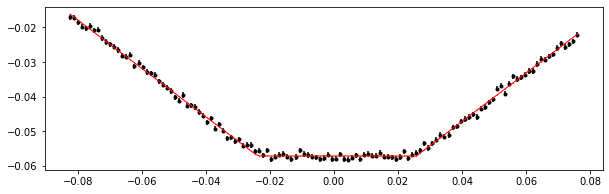

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.11it/s]


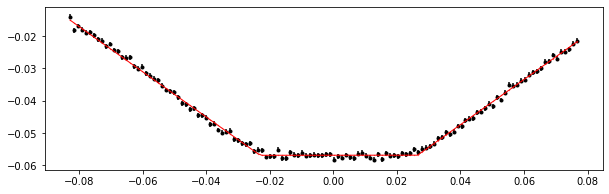

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.80it/s]


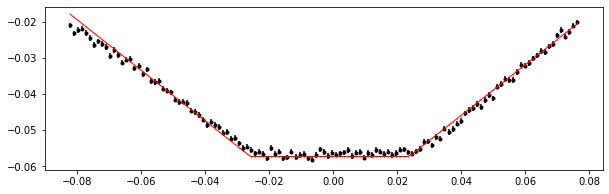

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.68it/s]


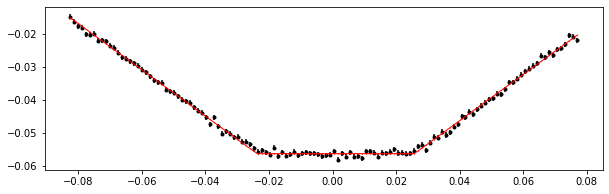

yes


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 100.98it/s]


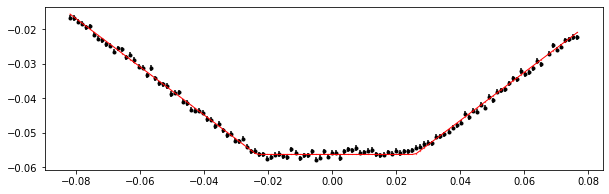

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.78it/s]


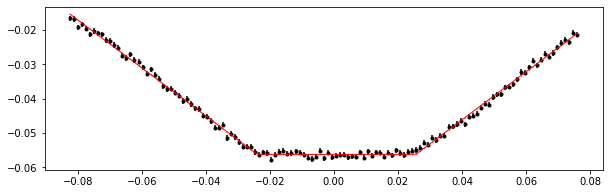

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.28it/s]


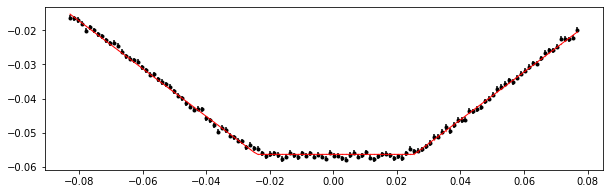

yes


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 100.32it/s]


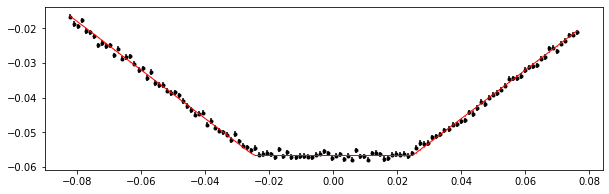

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.90it/s]


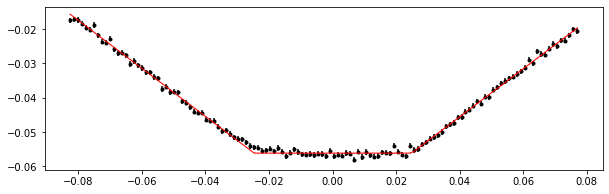

yes


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 100.82it/s]


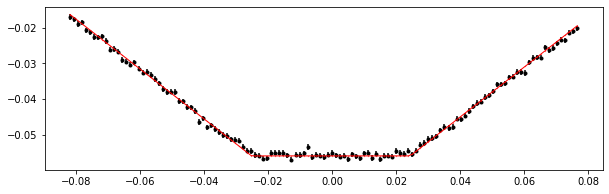

yes


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 101.06it/s]


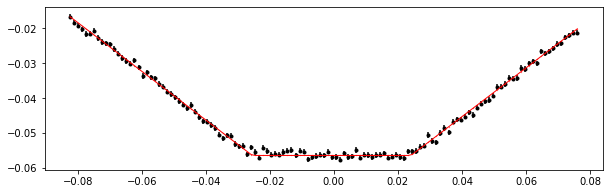

yes


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 100.43it/s]


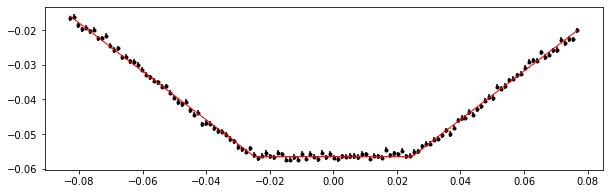

yes


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 101.27it/s]


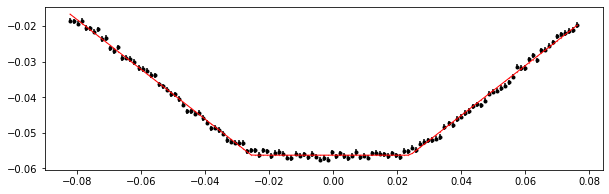

yes


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 100.47it/s]


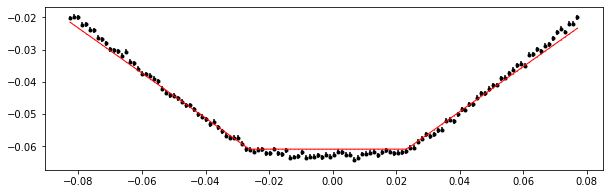

yes


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 100.85it/s]


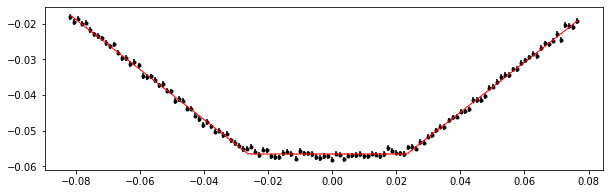

yes


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 101.14it/s]


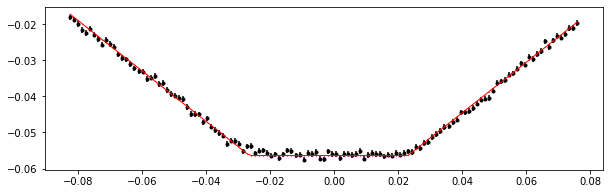

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.64it/s]


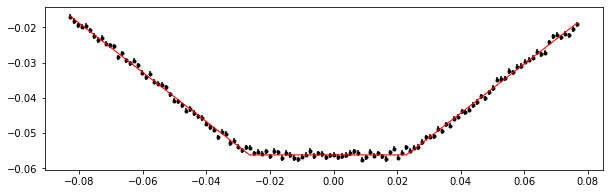

yes


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 100.69it/s]


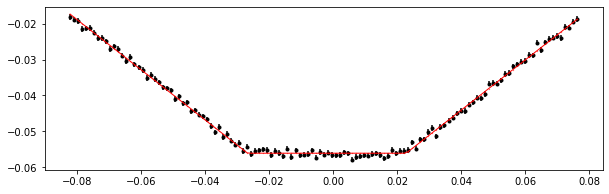

yes


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 100.81it/s]


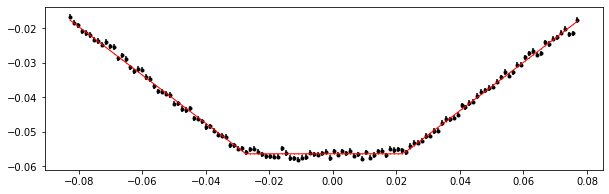

yes


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 100.71it/s]


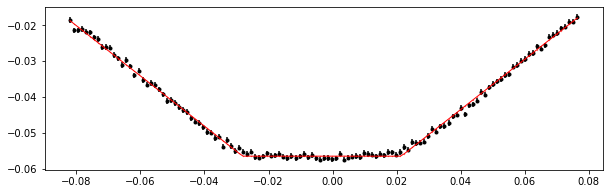

yes


100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 100.08it/s]


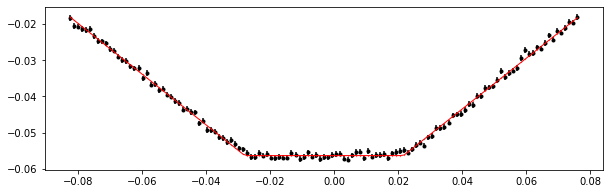

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 96.71it/s]


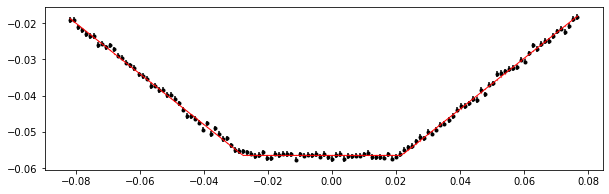

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.23it/s]


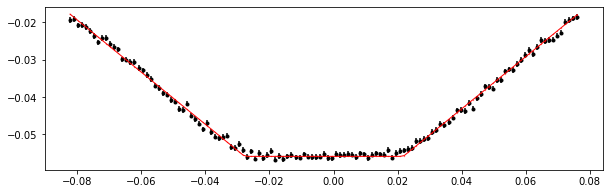

yes


100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.72it/s]


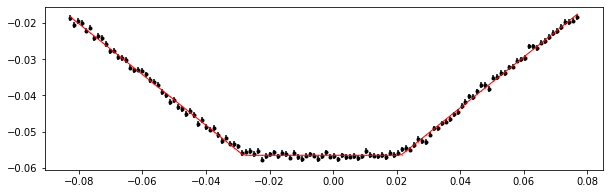

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.37it/s]


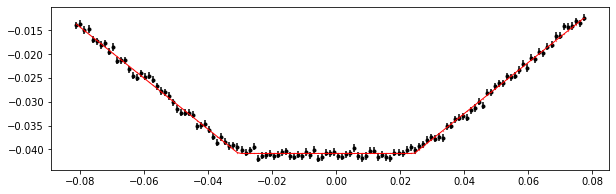

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.01it/s]


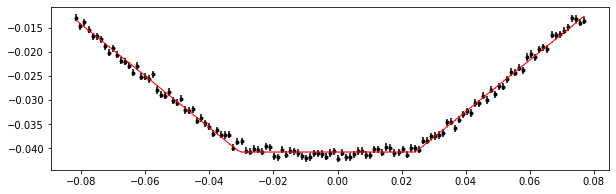

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.79it/s]


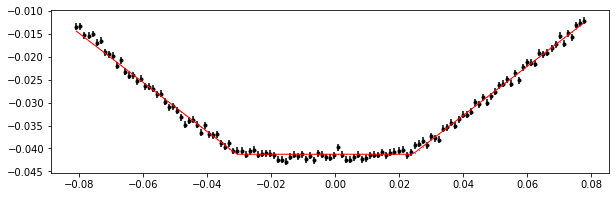

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.62it/s]


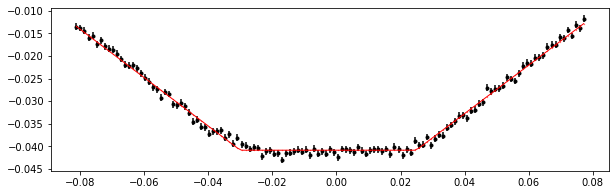

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 96.15it/s]


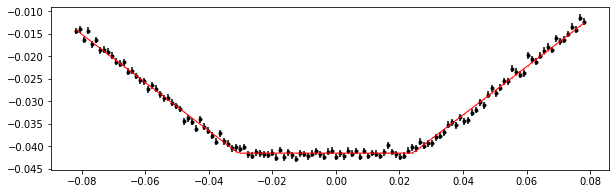

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.56it/s]


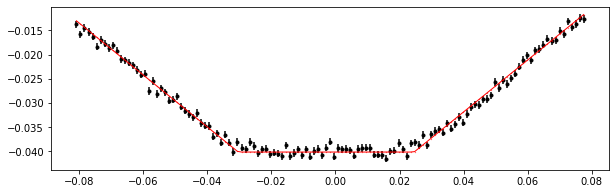

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.21it/s]


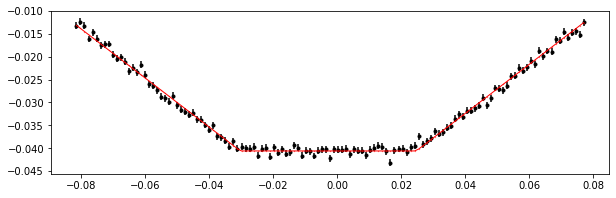

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.19it/s]


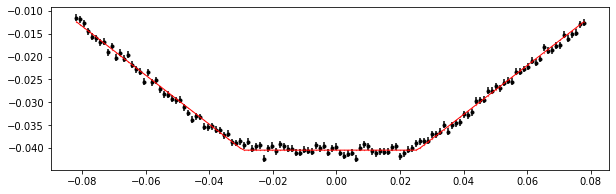

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.97it/s]


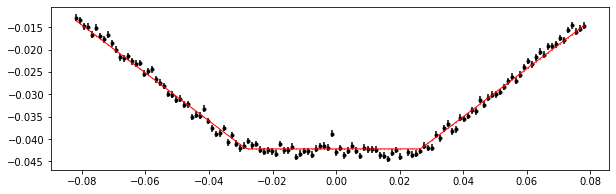

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.36it/s]


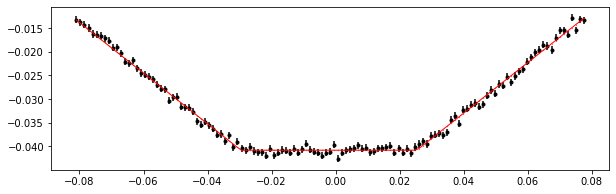

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.55it/s]


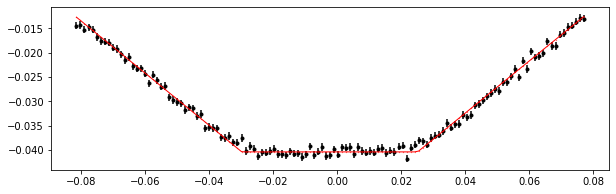

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.30it/s]


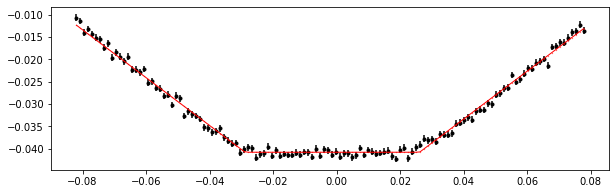

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.69it/s]


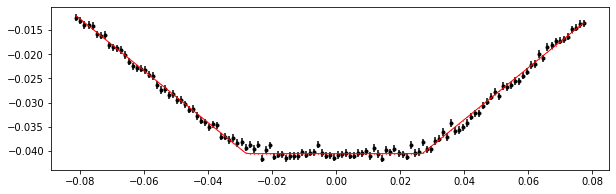

100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 100.44it/s]


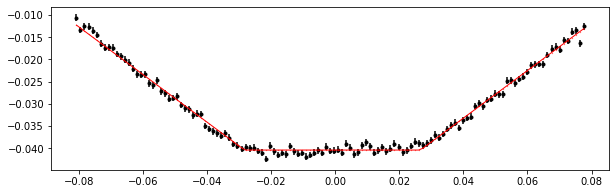

100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 101.15it/s]


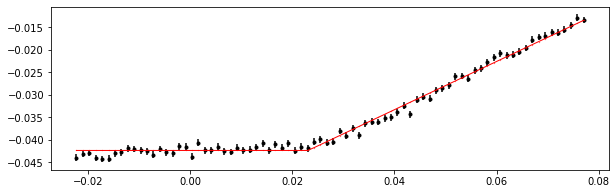

100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 100.41it/s]


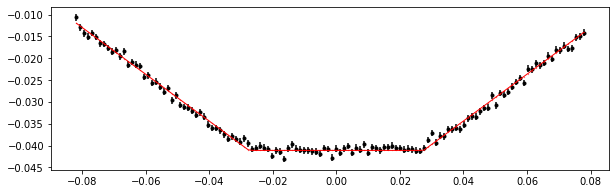

100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 101.36it/s]


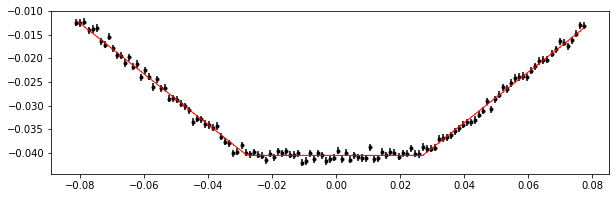

100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 100.77it/s]


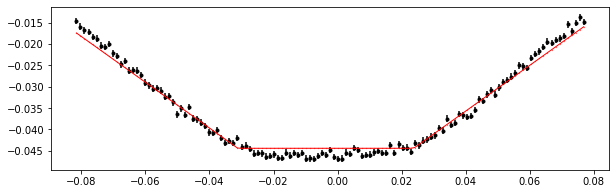

100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 101.16it/s]


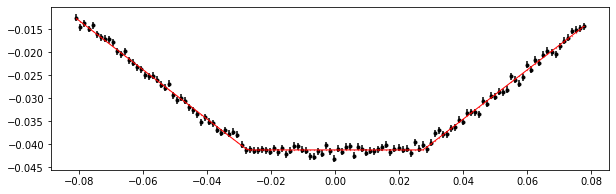

100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 100.49it/s]


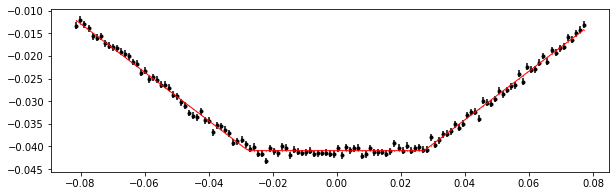

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.45it/s]


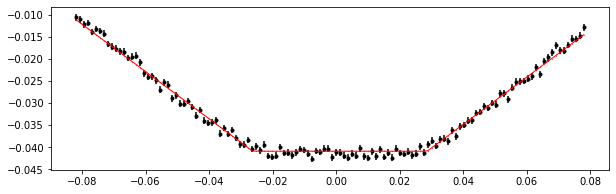

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 96.81it/s]


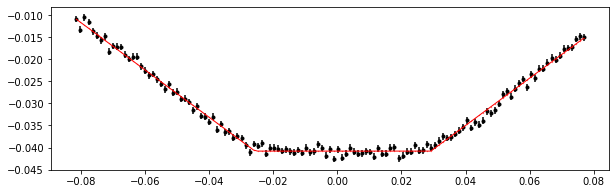

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.77it/s]


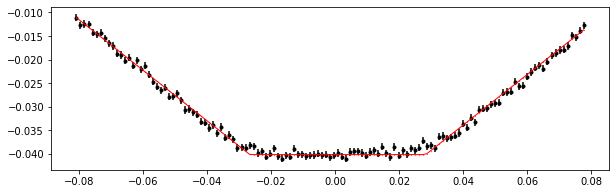

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.27it/s]


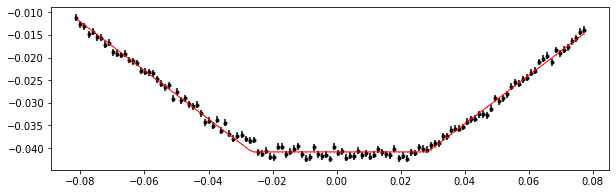

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 93.14it/s]


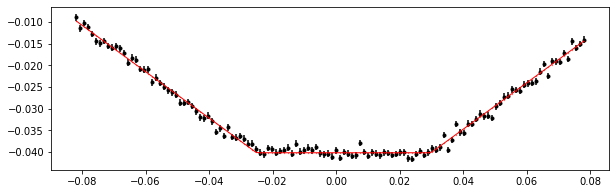

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.55it/s]


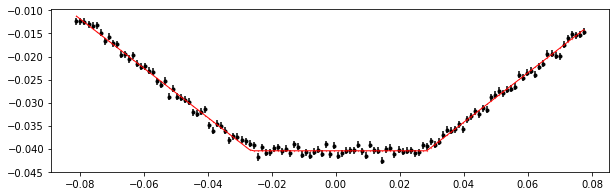

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.58it/s]


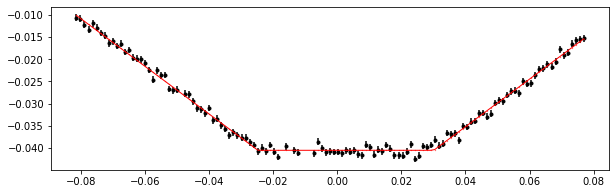

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.97it/s]


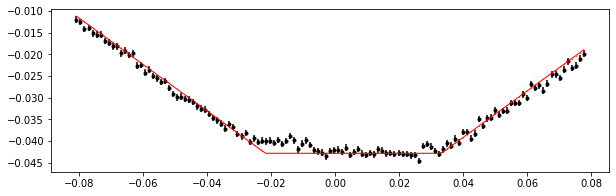

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.59it/s]


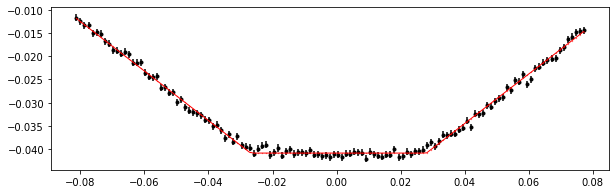

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.89it/s]


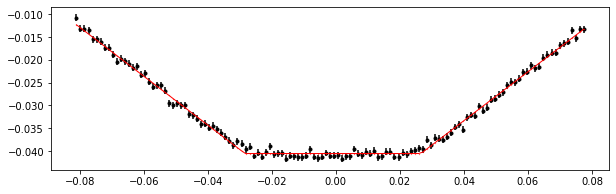

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.93it/s]


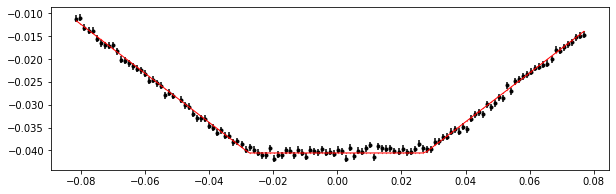

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.85it/s]


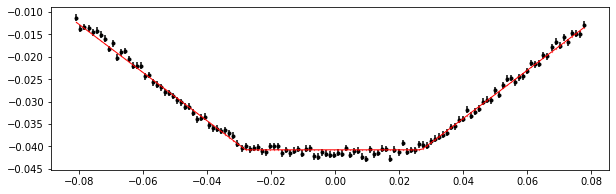

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.77it/s]


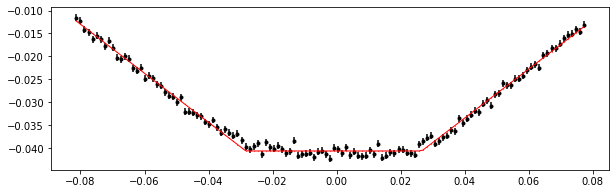

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 97.84it/s]


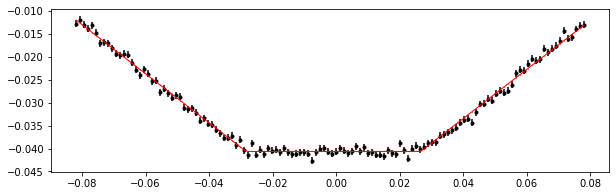

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.97it/s]


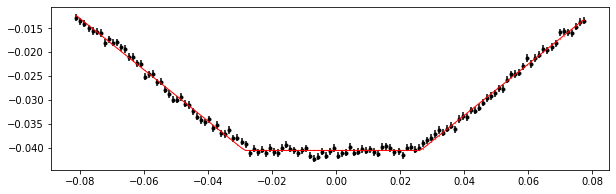

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.01it/s]


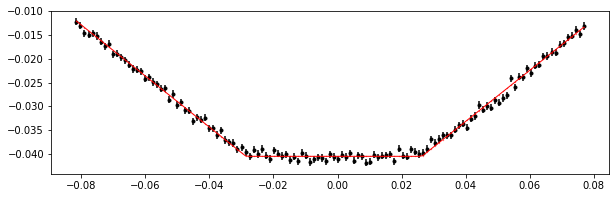

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 96.95it/s]


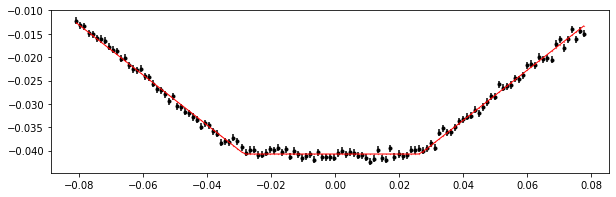

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.52it/s]


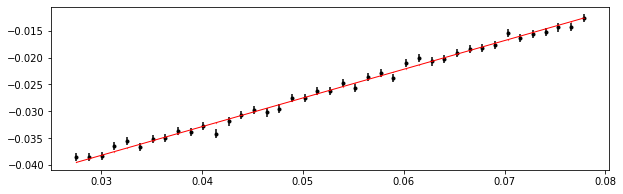

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 99.66it/s]


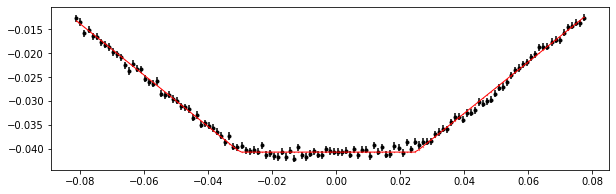

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.43it/s]


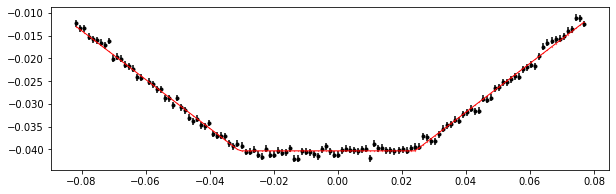

100%|██████████████████████████████████████| 1000/1000 [00:09<00:00, 100.44it/s]


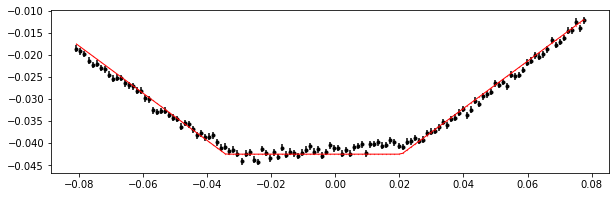

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.98it/s]


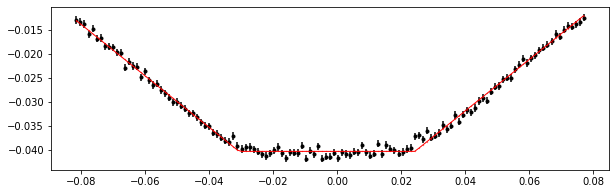

100%|███████████████████████████████████████| 1000/1000 [00:10<00:00, 98.52it/s]


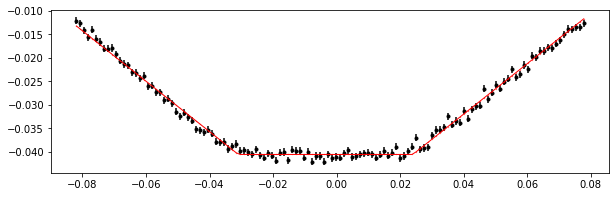

In [38]:
%matplotlib inline 
from os.path import basename, exists
import sys 
import csv

tr_index = range(-5000, 5000)

t0_primary = t0
t0_secondary = t0 - (period/2)

outfile_path = '/Users/neisner/Documents/projects/fluffy/reanalysed/onedaysignal/mcmc_etvs_primary_section{}_combined_data_period.csv'.format(section_number+1)
outfile_path_s = '/Users/neisner/Documents/projects/fluffy/reanalysed/onedaysignal/mcmc_etvs_secondary_section{}_combined_data_period.csv'.format(section_number+1)

if exists('{}'.format(outfile_path)):
    print("Existing manifest file found, will skip previously processed LCs and append to end of manifest file")
    sys.stdout.flush()


else:
    print("Creating new manifest file")
    sys.stdout.flush()
    metadata_header = ["number", 'epoch', 't0', 'amp', 'width', 'slope', 'offset', 'stdv']
       
    with open('{}'.format(outfile_path), 'w') as f: # save in the photometry folder
        writer = csv.writer(f, delimiter=',')
        writer.writerow(metadata_header)

# - - - - - - - - - - 

if exists('{}'.format(outfile_path_s)):
    print("Existing manifest file found, will skip previously processed LCs and append to end of manifest file")
    sys.stdout.flush()


else:
    print("Creating new manifest file")
    sys.stdout.flush()
    metadata_header = ["number", 'epoch', 't0', 'amp', 'width', 'slope', 'offset', 'stdv']
       
    with open('{}'.format(outfile_path_s), 'w') as f: # save in the photometry folder
        writer = csv.writer(f, delimiter=',')
        writer.writerow(metadata_header)

        
manifest_table = pd.read_csv('{}'.format(outfile_path))
manifest_table_s = pd.read_csv('{}'.format(outfile_path_s))

number_done = manifest_table['number']
number_done_s = manifest_table_s['number']


for i in tr_index:
    if not np.isin(i,number_done):
        
        transit_time = t0_primary+(period*i)
        
        x = np.array(time_primary)
        y = np.array(flux_primary)
        yerr = np.array(err_primary)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask])
        yerr = np.array(yerr[mask])
        
        x = np.array([-0.5+( ( t - t0_primary-0.5*period) % period) / period for t in x])
        
        if len(x) > 20:
            print ('yes')
            # starting vals
            start_vals = [0,0]
            
            pos = list(get_starting_positions(start_vals,nwalkers=64))[0]
            
            nwalkers = 64
            ndim = len(start_vals)
            
            # start the mcmc fitting
            sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_fitting, args=(x, y, yerr))
            
            sampler2.run_mcmc(pos, 1000, progress=True)
    
            flat_samples2 = sampler2.get_chain(discard=200, thin=15, flat=True)
            
            mean_t0_fit = np.nanmedian(flat_samples2[:,0])
            stdv_t0_fit = np.nanstd(flat_samples2[:,0])
            mean_offset_fit = np.nanmedian(flat_samples2[:,1])
    
            fig = plt.subplots(figsize=(10, 3), sharex=True)
            
            plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, zorder = -2)

            t_init = models.Trapezoid1D(amplitude=mean_amp, x_0=mean_t0_fit, width=mean_width, slope=mean_slope)
            model_mean = t_init(x) + mean_offset_fit

            plt.plot(x, model_mean, lw = 1, marker = '.', markersize = 0.5, alpha=1, zorder = 2, color= 'red')
    
            plt.show()
              
              
            with open('{}'.format(outfile_path), 'a') as f: # save in the photometry folder
                writer = csv.writer(f, delimiter=',')
                writer.writerow([i, transit_time, mean_t0_fit, mean_amp, mean_width, mean_slope, mean_offset_fit, stdv_t0_fit])
        else:  
            continue
    else:
        print ("Number {} has already been completed -- skip".format(i))
        
# - - - - - - - - - - - - - 

#print (" -------- {}".format(number_done_s))
for i in tr_index:
    #print (i)
    if not np.isin(i,number_done_s):
        
        transit_time = t0_secondary+(period*i)
        
        x = np.array(time_secondary)
        y = np.array(flux_secondary)
        yerr = np.array(err_secondary)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask])
        yerr = np.array(yerr[mask])
        
        x = np.array([-0.5+( ( t - t0_secondary-0.5*period) % period) / period for t in x])
        
        if len(x) > 20:
            # starting vals
            start_vals = [0,0]
            
            pos = list(get_starting_positions(start_vals,nwalkers=64))[0]
            
            nwalkers = 64
            ndim = len(start_vals)
            
            # start the mcmc fitting
            sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_probability_fitting_s, args=(x, y, yerr))
            
            sampler2.run_mcmc(pos, 1000, progress=True)
    
            flat_samples2 = sampler2.get_chain(discard=200, thin=15, flat=True)
            

            mean_t0_fit_s = np.nanmedian(flat_samples2[:,0])
            stdv_t0_fit_s = np.nanstd(flat_samples2[:,0])
            mean_offset_fit_s = np.nanmedian(flat_samples2[:,1])
    
            
            fig = plt.subplots(figsize=(10, 3), sharex=True)
            
            plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, zorder = -2)

            t_init = models.Trapezoid1D(amplitude=mean_amp_s, x_0=mean_t0_fit_s, width=mean_width_s, slope=mean_slope_s)
            model_mean = t_init(x) + mean_offset_fit_s

            plt.plot(x, model_mean, lw = 1, marker = '.', markersize = 0.5, alpha=1, zorder = 2, color= 'red')
    
            plt.show()
              
            with open('{}'.format(outfile_path_s), 'a') as f: # save in the photometry folder
                writer = csv.writer(f, delimiter=',')
                writer.writerow([i, transit_time, mean_t0_fit_s, mean_amp_s, mean_width_s, mean_slope_s, mean_slope_s, stdv_t0_fit_s])
        else:  
            continue
    else:
        continue

In [39]:
#in_df_binned = pd.read_csv('/Users/Nora/Documents/research/projects/fluffy/fluffy_etvs/mcmc_etvs_binned.csv')
#in_df_4d = pd.read_csv('/Users/Nora/Documents/research/projects/fluffy/fluffy_etvs/mcmc_etvs_4d.csv')


33
36
21
19
43
50


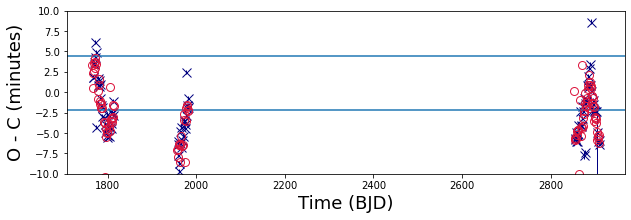

In [40]:
#%matplotlib notebook

fig = plt.subplots(figsize=(10, 3), sharex=True)

for sec_num in [0,1,2]:

    in_df_primary = pd.read_csv('/Users/neisner/Documents/projects/fluffy/reanalysed/oneday_orig_period/mcmc_etvs_primary_section{}_orig_period.csv'.format(sec_num +1))
    in_df_secondary = pd.read_csv('/Users/neisner/Documents/projects/fluffy/reanalysed/oneday_orig_period/mcmc_etvs_secondary_section{}_orig_period.csv'.format(sec_num +1))
    
    in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
    in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
    in_df_primary['std_mins'] = in_df_primary['stdv']*period*24*60
    
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv']*period*24*60
    
    #in_df_4d['midpoint'] = in_df_4d['epoch'] + (in_df_4d['t0']*period)
    #in_df_4d['shift_mins'] = in_df_4d['t0']*period*24*60
    print (len(in_df_secondary['midpoint']))
    print (len(in_df_primary['midpoint']))
    
    plt.errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
                 lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', markeredgecolor = 'crimson')
    plt.errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2 )
    
    #plt.errorbar(in_df_4d['epoch'], in_df_4d['shift_mins'], lw = 0, marker = '.', elinewidth = 1 )
    

#period_9 = 9.9733
#t0_9 = 1785.532657 - (period_9*3)

period_4 = 4.0919
t0_4 = 1769.27


#for i in range (0,55):
#
#    #plt.axvline(t0_9 + (i*period_9), alpha = 0.8, color = 'gold', zorder = -2)
#    plt.axvline(t0_4 + (i*period_4), alpha = 0.8, color = 'grey', zorder = -2)
#
plt.ylim(-10,10)

plt.axhline(4.5)
plt.axhline(-2.16)
plt.xlabel("Time (BJD)", fontsize = 18)
plt.ylabel("O - C (minutes)", fontsize = 18)
plt.show()



In [41]:
33 + 36 + 21 + 19 + 43 + 50

202